<h1><center> Analysis of Zipf's Law through analysis of summarization </center></h1>

<h2><center> Authors: Martin McCarley & Ankur Sahoo </center></h2>
<h3><center> CMSC320: Data Science </center></h3>

### Purpose

   The purpose of this project is to demonstrate the steps within the data science pipeline: Data Collection, Data Processing; Exploratory Analysis & Data Visualization; Analysis,Hypothesis Testing & Machine Learning; and Insight & Policy Decision. In this project we gather large blocks of text, in web(HTML) form, and analyze the words that occur and their number of occurances. The mysterious property that language tends to lend itself to, Zipf's Law, shows that the frequency of word occurance is almost always logrithmic. This has been theorized to be a result of how humans have evolved to explain the world around them in a format that is both easy to interpret, yet descriptive enough to the reciever of the information and easy enough to convey as the dissimnator of the information. 
    
   We hope that by analayzing word frequency and the words least commonly used, we can attempt to construct a broad summary of the text. The summary that will be output is at least one word and is compared against synonyms and other related words, in respect to the words that make up the title to see how closely the generated summary matches the article.

### Table of Contents:

1. [Introduction to Zipf's Law](#intro)
 
 
2. [Data Science Pipeline](#pipeline)
    - [Data Collection](#collect)
    - [Data Processing](#process)
    - [Exploratory Analysis](#eda)
    - [Data Visualization](#viz)
    - [Analysis](#analyze)
    - [Hypothesis Creation](#hypothesize)
    - [Hypothesis Testing](#test)
    - [Machine Learning](#ml)
    - [Insight & Policy Decision](#insight)
 
 
3. [Conclusions](#conclusions)

### Introduction to Zipf's Law

Zipf's law is an empirical law that is formulated using mathematical statistics. It states that if you are given a large sample of words, and you have a count of the number of occurences for all the words, the frequency of any word is inversely proportional to its rank in the frequency table.

So if you look at a word "n", that work has a frequeny proportional to 1/n. So due to this, the word that has the most occurences will occur approximately twice as often as the word with the second most frequent word, three times as often as the third word, and so on. As you go from words with the most frequencies to 
the words with the least frequency, the occurences will decline exponentially with word length. The theory is that the rank distribution arises naturally out of the fact that word length plays a part. Long words tend not to be very common, while shorter words are. It is easy to see how this has occurred in the evolution of language.

## Data Pipeline

### Data Collection

The first process in the data science pipeline is to collect the data that is necessary in the computations defined by your hypothesis. To collect the data we used article driven websites focused on specific topics within an individual domain as to avoid ambiguity in summarization.

In [299]:
# Imports needed in the Data Collection process
import requests
from bs4 import BeautifulSoup
from string import punctuation
from collections import Counter

For each website that was used as a source for testing data we created a parser for that website to avoid the nuances of webpage styles.

In [300]:
# https://www.dissentmagazine.org/article/the-new-tech-culture-wars

# This function defines how to scrape the web article from www.dissentmagazine.org
# Input: 
#  The function takes in the full url or the portion of the url that comes after the web domain.
#   For example the input argument would be /article/the-new-tech-culture-wars for the article
#   at https://www.dissentmagazine.org/article/the-new-tech-culture-wars
# Output:
#  The function returns a tuple containing a dictionary of the words in the body of the article 
#   and the number of occurances for each word.
def parse_dissentmagazine(url):
    
    # The dissent magazine web domain URL
    dissent_magazine_base_url = 'https://www.dissentmagazine.org'
    
    # Raises an error if the homepage is passed in
    if url == dissent_magazine_base_url:
        raise('Invalid Article')
    
    # Generates the url to request from using the input full url or url portion
    if dissent_magazine_base_url in url: # Checks if input is full url
        request_url = url # Sets request url equal to the full  url
    else:
        need_slash = '/' if url[0] != '/' else '' # Checks if the partial url contains a leading forward slash
        request_url = dissent_magazine_base_url + need_slash + url # Builds the full url and sets request url to it
        
    
    request = requests.get(request_url) # Requests the article page
    soup = BeautifulSoup(request.content) # Parses the HTML file using Beautiful Soup
    
    # Grabs the article
    article = soup.find(id='article') # Grabs the article container tag
    
    # Grabs the article title from the header tag within the container
    article_title = article.find('header').find('h1').find(text=True).strip()
    
    # Grabs all of the text within the article 
    article_text = ''
    for noodle in article.findAll('p'):
        article_text += ' '.join(noodle.findAll(text=True))

    # Cleans up the text by spliting every word, removing punctuation and changing all words to lower case
    clean_article_text = []
    for line in article_text.split():
        for word in line.split('.'):
            for clean_word in word.split('-'):
                for cw in clean_word.split('—'):
                    clean_article_text.append(cw.strip(punctuation).lower())
    
    # Filters out punctuation from the word list
    retdict = []
    for c in clean_article_text:
        word = c.strip(punctuation) 
        if not word in punctuation:
            retdict.append(word)
    
    # Converts the cleaned result to a dictionary
    retdict = dict(Counter(retdict))
    
    return (article_title, retdict)

### Data Processing (Data Cleaning)

In the Data Processing step we put the article data, a dictionary containing the words found in the article and the frequency at which they occured, into a DataFrame and tidy it. In addition, we create an article_stats DataFrame, which is populated with values computed from the data to be further analyzed in the Exploratory Analysis step. 

#### Imports

In [301]:
# Import Libraries for Data processing
import pandas as pd # A powerful data structure library
import numpy as np # A powerful scientific library

#### Functions

Function: frequency_greater_than

Description: Counts how many words in the given Dataframe were used more than the given number, x, times

Input:
 - *df*:  an article DataFrame
 - *x*:  a scalar numerical value
 
Output:
 - *df*:  an article DataFrame, equivalent to mapping frequency >= x across every value in the 'Frequency' column of                the article DataFrame
 - *count*:  an Integer Series, representing the number of True and False values in mapped

In [302]:
def frequency_greater_than(df, x):
    
    # Creates a series that maps the result of frequency >= x
    df['gtAWF'] = df['Frequency'].gt(x)
    
    # Creates a Series summing the number of occurances
    count = df['gtAWF'].value_counts()

    # Returns the Series and the count 
    return df, count

Function: weight_greater_than

Decription: Counts how many words in the given Dataframe have more weight than the given number, x, times

Input:
 - *df*: an article DataFrame
 - *twc*: an integer, the total word count of the given article
 - *x*: a scalar numerical value

Output:
 - *df*: the given article DataFrame, populated with Overall and Individual Weight columns
 - *count*: an Integer Series, representing the number of True and False values in overall_mapped

In [303]:
def weight_greater_than(df, twc, x):
    
    # Creates the 'Overall' Weight column
    df['Overall Weight'] = df['Frequency'] / twc
    
    overall_mapped = df['Overall Weight'].gt(x)
    
    # Creates a Series summing the number of occurances
    count = overall_mapped.value_counts()

    # Returns the Series and the count 
    return df, count

Function: create_article_df

Description: Given a Dataframe(df) and a dict(data): populates the DataFrame, sorts the values descending by the 'Frequency', and creates a 'Rank' column, ranking each Frequency in descending order.

Input:
 - *df*: an empty DataFrame
 - *data*: a dictionary, in form, { 'word1': frequency1, ..., 'wordn': frequencyn

Output:
 - *df*: the given DataFrame populated using the passed in data

In [304]:
def create_article_df(df, data):
    
    df['Word'] = data.keys() # Creates a 'Word' column using the keys of the given data
    df['Frequency'] = data.values() # Creates a 'Frequency' column using the values of the given data
    
    # Sorts the Dataframe by the values in the 'Frequency' column in descending order
    df.sort_values(by='Frequency',inplace=True,ascending=False)

    # Creates a 'Rank' column, which ranks each frequency in decending order
    df['Rank'] = df['Frequency'].rank(ascending=False)
    
    # Resets the index of the DataFrame and drops the old index values
    df.reset_index(drop=True, inplace=True)
    
    return df

Function: compute_article_stats

Description: Computes different statistics about the article from the given article DataFrame

Input:
 - *df*: an article DataFrame
 - *title*: a string, representing the article's title

Output:
 - *df*: the article DataFrame, populated with calculated information\
 - *stats*: a Series, containing the given article's stats
     - Unique Word Count (UWC)
     - Total Word Count (TWC)
     - Average Word Frequency (AWF)
     - \# of Words with Frequency > AWF (gtAWF)
     - \# of Words with Frequency <= AWF (leAWF)
     - % of Words with Frequency > AWF (gtAWF%)
     - % of Words with Frequency <= AWF (leAWF%)
     - Average Word Weight (AWW)
     - \# of Words with Word Weight > AWW (gtAWW)
     - \# of Words with Word Weight <= AWW (leAWW)
     - % of Words with Word Weight > AWW (gtAWW%)
     - % of Words with Word Weight <= AWW (leAWW%)

In [305]:
# Input: an article Dataframe
# Ouput: a Series, containing the article's stats
def compute_article_stats(df, title):
    
    # Computes the unique word count by grabbing the number of rows in the DataFrame
    article_uwc = df.shape[0]
    
    # Computes the total word count by summing all the frequencies of the 'Frequency' column
    article_twc = df['Frequency'].sum()
    
    # Computes average word frequency
    article_awf = article_twc / article_uwc
    
    # Computes the count of words that occur more than the average word frequency
    article_gtawf = frequency_greater_than(df, article_awf)[1][True]
    
    # Computes the count of words that occur less than or equal to the average word frequency
    article_leawf = frequency_greater_than(df, article_awf)[1][False]
    
    # Computes the percent of words that occur more than the average word frequency
    article_gtawf_percent = (article_gtawf / article_uwc) * 100
    
    # Computes the percent of word that occur less than or equal to the average word frequency
    article_leawf_percent = (article_leawf / article_uwc) * 100
    
    # Computes the average unique word weight
    article_aww = np.array([x / article_uwc for x in (df['Frequency'] / article_twc)]).sum()
    
    # Computes the count of words that have weight greater than the average word weight
    # Computes the count of words that have weight less than or equal to the average word weight
    df, article_aww_count = weight_greater_than(df, article_twc, article_aww)
    article_gtaww, article_leaww = article_aww_count[True], article_aww_count[False]
    
    # Computes the percent of words that have weight greater than the average word weight
    article_gtaww_percent = (article_gtaww / article_uwc) * 100
    
    # Computes the percent of words that have weight less than or equal to the average word weight
    article_leaww_percent = (article_leaww / article_uwc) * 100
    
    # Creates stats Series
    stats = pd.Series(data={'UWC': article_uwc, 'TWC': article_twc, 'AWF': article_awf, 
                            'gtAWF': article_gtawf, 'leAWF': article_leawf, 'gtAWF%': article_gtawf_percent, 
                            'leAWF%': article_leawf_percent, 'AWW': article_aww, 'gtAWW': article_gtaww,
                            'leAWW': article_leaww, 'gtAWW%': article_gtaww_percent,'leAWW%': article_leaww_percent,})
    
    # Names the Series after the Article's Title
    stats.name = title
    
    return df, stats

####  Article Stats Creation

In [306]:
# Create the Article Stats DataFrame
article_stats = pd.DataFrame()

####  Article One: The New Tech Culture Wars

In [307]:
# Scrape the given webpage, using the parser
article1_title, article1_data = parse_dissentmagazine('https://www.dissentmagazine.org/article/the-new-tech-culture-wars')

In [308]:
# Creates the DataFrame to be populated with the article1_data
article1_df = pd.DataFrame()

# Using the article1_data, in the form of a dict containing the 'Word' as a key and the'Frequency' as a value,
#  Creates the 'Word' and 'Frequency' columns
# Populates the article1_df DataFrame with the article_data
article1_df = create_article_df(article1_df, article1_data)

# Computes the stats for article one 
article1_df, article1_stats = compute_article_stats(article1_df, article1_title)

# Adds article1_stats to the article_stats DataFrame
article_stats[article1_stats.name] = article1_stats

##### Article One DataFrame

In [309]:
article1_df

,Word,Frequency,Rank,gtAWF,Overall Weight
0,the,278,1.0,True,0.064456
1,of,153,2.0,True,0.035474
2,to,126,3.0,True,0.029214
3,and,95,4.0,True,0.022026
4,in,85,5.0,True,0.019708
...,...,...,...,...,...
1571,influencers,1,1035.5,False,0.000232
1572,operators,1,1035.5,False,0.000232
1573,special,1,1035.5,False,0.000232
1574,mobilization,1,1035.5,False,0.000232


##### Article One Stats

In [310]:
article1_stats

UWC       1576.000000
TWC       4313.000000
AWF          2.736675
gtAWF      268.000000
leAWF     1308.000000
gtAWF%      17.005076
leAWF%      82.994924
AWW          0.000635
gtAWW      268.000000
leAWW     1308.000000
gtAWW%      17.005076
leAWW%      82.994924
Name: The New Tech Culture Wars, dtype: float64

#### Article Two: Water Democracy

In [311]:
# Scrape the given webpage, using the parser
article2_title, article2_data = parse_dissentmagazine('https://www.dissentmagazine.org/online_articles/water-democracy')

In [312]:
# Creates the DataFrame to be populated with the article1_data
article2_df = pd.DataFrame()

# Using the article1_data, in the form of a dict containing the 'Word' as a key and the'Frequency' as a value,
#  Creates the 'Word' and 'Frequency' columns
# Populates the article1_df DataFrame with the article_data
article2_df = create_article_df(article2_df, article2_data)

# Computes the stats for article one 
article2_df, article2_stats = compute_article_stats(article2_df, article2_title)

# Adds article1_stats to the article_stats DataFrame
article_stats[article2_stats.name] = article2_stats

##### Article Two DataFrame

In [313]:
article2_df

,Word,Frequency,Rank,gtAWF,Overall Weight
0,the,332,1.0,True,0.070488
1,of,162,2.0,True,0.034395
2,to,143,3.0,True,0.030361
3,a,122,4.0,True,0.025902
4,in,95,5.0,True,0.020170
...,...,...,...,...,...
1744,bullet,1,1143.0,False,0.000212
1745,dozens,1,1143.0,False,0.000212
1746,empty,1,1143.0,False,0.000212
1747,hill,1,1143.0,False,0.000212


##### Article Two Stats

In [314]:
article_stats

,The New Tech Culture Wars,Water Democracy
UWC,1576.000000,1749.000000
TWC,4313.000000,4710.000000
AWF,2.736675,2.692967
gtAWF,268.000000,294.000000
leAWF,1308.000000,1455.000000
gtAWF%,17.005076,16.809605
leAWF%,82.994924,83.190395
AWW,0.000635,0.000572
gtAWW,268.000000,294.000000
leAWW,1308.000000,1455.000000


#### Article Three: Design for a Green Future

In [315]:
# Scrape the given webpage, using the parser
article3_title, article3_data = parse_dissentmagazine('https://www.dissentmagazine.org/article/design-for-a-green-future')

In [316]:
# Creates the DataFrame to be populated with the article1_data
article3_df = pd.DataFrame()

# Using the article1_data, in the form of a dict containing the 'Word' as a key and the'Frequency' as a value,
#  Creates the 'Word' and 'Frequency' columns
# Populates the article1_df DataFrame with the article_data
article3_df = create_article_df(article3_df, article3_data)

# Computes the stats for article one 
article3_df, article3_stats = compute_article_stats(article3_df, article3_title)

# Adds article1_stats to the article_stats DataFrame
article_stats[article3_stats.name] = article3_stats

##### Article Three DataFrame

In [317]:
article3_df

,Word,Frequency,Rank,gtAWF,Overall Weight
0,the,34,1.0,True,0.060606
1,and,27,2.0,True,0.048128
2,of,22,3.0,True,0.039216
3,a,14,4.0,True,0.024955
4,to,13,5.0,True,0.023173
...,...,...,...,...,...
322,absence,1,200.5,False,0.001783
323,given,1,200.5,False,0.001783
324,urbanists,1,200.5,False,0.001783
325,bruce,1,200.5,False,0.001783


##### Article Three Stats

In [318]:
article_stats

,The New Tech Culture Wars,Water Democracy,Design for a Green Future
UWC,1576.000000,1749.000000,327.000000
TWC,4313.000000,4710.000000,561.000000
AWF,2.736675,2.692967,1.715596
gtAWF,268.000000,294.000000,73.000000
leAWF,1308.000000,1455.000000,254.000000
gtAWF%,17.005076,16.809605,22.324159
leAWF%,82.994924,83.190395,77.675841
AWW,0.000635,0.000572,0.003058
gtAWW,268.000000,294.000000,73.000000
leAWW,1308.000000,1455.000000,254.000000


**Quick nav**

[Data Visualization](#viz), [Analysis](#analyze), [Hypothesis Creation](#hypothesize), [Hypothesis Testing](#test), [Machine Learning](#ml), [Insight & Policy Decision](#insight), [Conclusions](#conclusions)

### Exploratory Analysis 
- [Understanding the article_stats](#edafunc)
- [Article One](#article1)

In [319]:
article_stats

,The New Tech Culture Wars,Water Democracy,Design for a Green Future
UWC,1576.000000,1749.000000,327.000000
TWC,4313.000000,4710.000000,561.000000
AWF,2.736675,2.692967,1.715596
gtAWF,268.000000,294.000000,73.000000
leAWF,1308.000000,1455.000000,254.000000
gtAWF%,17.005076,16.809605,22.324159
leAWF%,82.994924,83.190395,77.675841
AWW,0.000635,0.000572,0.003058
gtAWW,268.000000,294.000000,73.000000
leAWW,1308.000000,1455.000000,254.000000


The UWC is the number of unique words found within the text, which is equal to the number of entries in the article's DataFrame. The TWC, total word count, is equal to the sum across all values of the article's 'Frequency' column.  

The AWF is the average word frequency, calculated if each word had equal weight. gtAWf, refers to the number of words that had a frequency of occurance higher than the average; leAWF refers to the number of words that occured less than or equal to the average word frequency. gtAWF% and leAWF%, refers to these numbers respectively as percentages in repsect to the number of unique words. 

The AWW, average word weight, is the weight of each unique word. gtAWW, refers to the number of words that have an overall weight higher than the average word weight; leAWW refers to the number of words that have an overall weight less than or equal to the average word weight. gtAWW% and leAWW%, refers to these numbers respectively as percentages in repsect to the number of unique words. 

#### Article One

As one can see from the stats table, for article one: The New Tech Culture Wars, that the gtAWF = gtAWW, leAWF = leAWW, gtAWF% = gtAWW%, and leAWF% = leAWW%. This shows us that the weight of each word is balanced when the  frequency of each word is balanced.

This balance, is of course, not the case as can see that the data tends to lends itself to some curve as the frequency of words continuously decreases from the value of the highest word occurance to 1 and leveling off. 

From the AWW we can gather that if we were to reconstruct article one such that each word had equal weight, each word making up 0.000635 of the article, in terms of frequncy, each word would occur between two and three times. 

In [320]:
# The rank denoting the split between gtAWW/gtAWF & leAWW/leAWF
stop_rank = int(article_stats.at['gtAWW', article1_title])

# Calculates the Total weight of the words with a weight greater than the AWW
gt_total_weight = article1_df['Overall Weight'][:stop_rank].sum()


gt_total_weight

0.6443310920472989

This tells us that approximately 17.06% of the words make up 64.43% of the weight of the article.

In [321]:
article1_twc = int(article_stats.at['TWC', article1_title])

# Calculates the Total Frequency of the words with a frequency greater than the AWF
gt_total_frequency = article1_df['Frequency'][:stop_rank].sum()

le_total_frequency = article1_df['Frequency'][stop_rank:].sum()

gt_total_frequency / article1_twc

0.6443310920472989

We know that weight and frequency are interchangeable, proven above asthe numbers are the same. This tells us that 17.06% of the words also account for 64.43% of all the words written in the article. From this we can calculate that approximately 83% of the words used only account for roughly 35.57% of the words contained in the article. 

### Data Visualization

An important step in the data science pipeline is data visualization. This step allows us to compare different data points and compare relations, allowing us to further analyze the data we have, possibly finding correlations. 

#### Imports

In [322]:
import seaborn as sb
import matplotlib.pyplot as plt
import math as m

Visualization 1: Rank(x) vs. Frequency(y) Scatter Plot

The purpose of this scatter plot is to visually analyze the trend of Frequency in relation to Rank

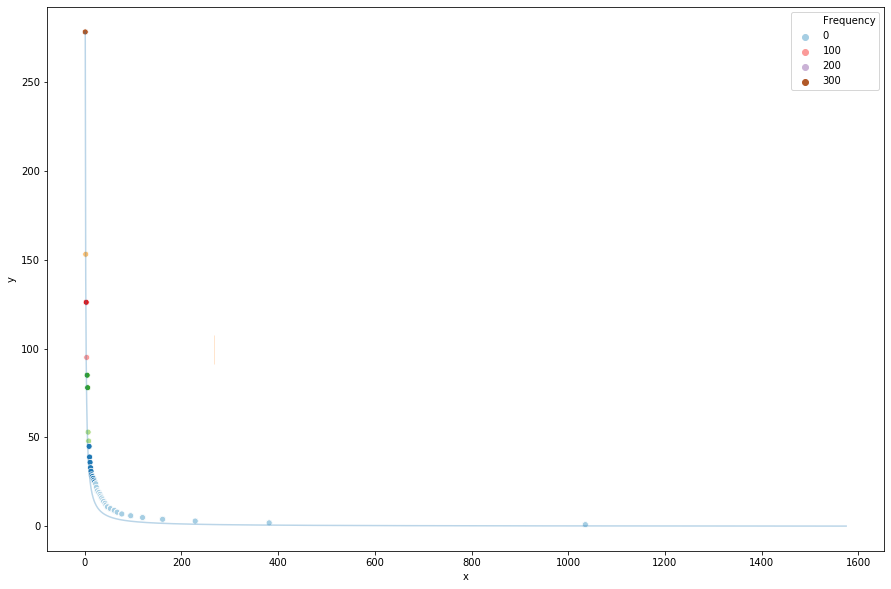

In [325]:
# Graphs the Rank vs. Frequency 
sb.scatterplot(x='Rank',y='Frequency',data=article1_df,hue='Frequency',palette='Paired',markers=True)

# Creates a logdf DataFrame containing the x->y function y =  article1_max_frequecy / x
x = range(1,len(article1_df),1)
logdf = pd.DataFrame(data={'x': x})
logdf['y'] = logdf['x'].apply(lambda x: article1_df['Frequency'][0]/x)

# Graphs the logrithmic curve created above, transparently
sb.lineplot(x='x',y='y',data=logdf, alpha=0.3)

# Increases the plot size to 15 inches by 10 inches
fig = plt.gcf()
fig.set_size_inches(15, 10, forward=True)

Here we have plotted the word rank versus the frequency. As we can see from the plot, the frequency relative to the rank follows an exponential decay curve, in accordance with Zipf's law. This means that higher ranking words are used exponentially more than lower ranking ones. 

In [ ]:
# Creates the loglog DataFrame for the Rank and Frequency values to be plotted on a loglog graph
loglog_df = pd.DataFrame()
loglog_df['Rank'] = article1_df['Rank'].apply(lambda x: m.log(x))
loglog_df['Frequency'] = article1_df['Frequency'].apply(lambda x: m.log(x))

# Graphs the the log of the rank vs the log of the frequency, also uses linear regression to predict the line of
#  best fit
sb.lmplot(x='Rank',y='Frequency',data=loglog_df)

This plot again shows the word rank versus frequency. However, this time we plotted on a log scale, meaning we plotted the log rank versus the log frequency. According to Zipf's law, we should expect to see a significant linear trend, which we do.

It is quite easy to see the trend of Zipf's Law in a graph such as this. As such, it has been used to model many other topics.

### Analysis (Hypothesis Creation)

From all the data thus presented, we can see that a small portion of the word make up a large percent of the article and that the most frequent words don't usually have meaning inherent to itself.

Our hypothesis is that we want to determine whether the least commonly used words are integral to understanding the concept. We want to look at the least commonly used words and see if they are associated with the main topic of the article. We want to analyze all the frequencies of the words to determine which frequencies matter more to the article compared to the other words.

### Insight & Policy Decision

In our testing, we noticed that the least commonly used words were still important to the understanding of the article. This shows us that the least commonly used words were enough to get us an extremely broad summary. In furture analytics, studying exactly how much impact these words have could serve to better the way we translate information to one antoher.